# League of Legends Match Predictor

### Overview

League of Legends (LOL) is a popular multiplayer game consisting of a wide number of matches with player statistics. This project will examine a LOL dataset to build a logisitic regression model that predicts the outcome of a match. The dataset is stored in a .csv file named `league_of_legends_data_large.csv`. There are 8 feature columns and one target column (win).

### Step 1: Data Loading and Preprocessing

The following actions will be taken:
- the dataset will be loaded into a pandas DataFrame
- the size, overview, and statistics of the dataset will be examined
- the dataset will be split into training and testing sets at an 80-20 split with `sklearn`
- features will be standardized using `StandardScaler`
- target and feature sets will be converted to tensors
- training and test datasets will be constructed with `TensorDataset` and loaded into `DataLoader` objects

#### Import libraries

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

#### Load the Data

In [2]:
# load dataset into a pandas DataFrame
df = pd.read_csv('league_of_legends_data_large.csv')
df.head()

,win,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
0,0,16,6,19,17088,231,11,7,15367
1,1,8,8,5,14865,259,10,2,38332
2,0,0,17,11,15919,169,14,5,24642
3,0,19,11,1,11534,264,14,3,15789
4,0,12,7,6,18926,124,15,7,40268


In [3]:
# check the shape
df.shape

(1000, 9)

In [4]:
# examine data overview (no missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   win           1000 non-null   int64
 1   kills         1000 non-null   int64
 2   deaths        1000 non-null   int64
 3   assists       1000 non-null   int64
 4   gold_earned   1000 non-null   int64
 5   cs            1000 non-null   int64
 6   wards_placed  1000 non-null   int64
 7   wards_killed  1000 non-null   int64
 8   damage_dealt  1000 non-null   int64
dtypes: int64(9)
memory usage: 70.4 KB


In [5]:
# look at data statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
win,1000.0,0.510,0.500150,0.0,0.00,1.0,1.00,1.0
kills,1000.0,9.332,5.798569,0.0,4.00,9.0,14.00,19.0
deaths,1000.0,9.487,5.773488,0.0,4.00,9.0,14.00,19.0
assists,1000.0,9.395,5.765086,0.0,4.00,10.0,14.00,19.0
gold_earned,1000.0,12433.808,4388.138751,5002.0,8551.75,12295.0,16348.25,19955.0
cs,1000.0,181.213,72.114910,50.0,121.00,183.5,243.00,299.0
wards_placed,1000.0,9.834,5.739633,0.0,5.00,10.0,15.00,19.0
wards_killed,1000.0,4.541,2.906332,0.0,2.00,5.0,7.00,9.0
damage_dealt,1000.0,27484.905,13221.571932,5028.0,15759.00,27370.0,39453.00,49927.0


Check if the target is balanced.

In [6]:
df['win'].value_counts(normalize=True)

win
1    0.51
0    0.49
Name: proportion, dtype: float64

#### Data Preprocessing

In [7]:
# separate features and target
X = df.copy()
y = X.pop('win')

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

# scale feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert training and test sets to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# create a TensorDataset object for the training and testing sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# create a DataLoader object for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)



### Step 2: Logistic Regression Model

#### Model Architecture

To define a custom logistic model class, the model will inherit from the nn.Module class in PyTorch. The activation function is sigmoid for logistic regression, and there will be two neurons in the output layer, representing whether or not a game was won or lost. Since there are 8 features, the input layer will have 8 neurons.

#### Optimizer and Loss Function

Stochastic Gradient Descent (SGD) will be used as the optimizer leveraging the `torch.optim` module. The loss function will be `CrossEntropyLoss`.

In [8]:
class LogisticRegressionNet(nn.Module):
    def __init__(self, input):
        super(LogisticRegressionNet, self).__init__()
        self.linear = nn.Linear(input, 2) # only one fully connected layer needed
    
    # calculate yhat
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

# instantiate model
model = LogisticRegressionNet(8)

# set optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

### Step 3: Model Training

The model will be trained on the training set for 10 epochs. The training and test loss will be calculated and stored for each epoch.

First, the helper function will be defined:

In [23]:
def model_training_eval(
    train_loader,
    test_loader, 
    model, 
    criterion, 
    optimizer, 
    epochs,
    show_losses=True
    ):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        all_preds = []
        all_labels = []
        # evaluation
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)
                # compile true values and predicted values
                _, preds = torch.max(test_outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        all_preds = torch.tensor(all_preds)
        all_labels = torch.tensor(all_labels)

        if show_losses == True:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses, all_preds, all_labels

In [10]:
# train the model
train_losses, test_losses, all_preds, all_labels = model_training_eval(
    train_loader=train_loader,
    test_loader=test_loader,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10
)

Epoch [1/10], Train Loss: 0.6999, Test Loss: 0.6901
Epoch [2/10], Train Loss: 0.6968, Test Loss: 0.6902
Epoch [3/10], Train Loss: 0.6944, Test Loss: 0.6905
Epoch [4/10], Train Loss: 0.6925, Test Loss: 0.6910
Epoch [5/10], Train Loss: 0.6909, Test Loss: 0.6916
Epoch [6/10], Train Loss: 0.6897, Test Loss: 0.6923
Epoch [7/10], Train Loss: 0.6887, Test Loss: 0.6930
Epoch [8/10], Train Loss: 0.6880, Test Loss: 0.6937
Epoch [9/10], Train Loss: 0.6874, Test Loss: 0.6944
Epoch [10/10], Train Loss: 0.6870, Test Loss: 0.6950


### Step 4: Model Optimization and Evaluation

The intial model has high training and test losses. The optimizer parameters will be adjusted.

In [11]:
model_2 = LogisticRegressionNet(8)
adjusted_optimizer = optim.SGD(model_2.parameters(), lr=0.05, momentum=0.09, weight_decay=0.0001)

# train the model with the updated optimizer
train_losses, test_losses, all_preds, all_labels = model_training_eval(
    train_loader=train_loader,
    test_loader=test_loader,
    model=model_2,
    criterion=criterion,
    optimizer=adjusted_optimizer,
    epochs=10
)

Epoch [1/10], Train Loss: 0.6953, Test Loss: 0.6956
Epoch [2/10], Train Loss: 0.6903, Test Loss: 0.6967
Epoch [3/10], Train Loss: 0.6889, Test Loss: 0.6980
Epoch [4/10], Train Loss: 0.6884, Test Loss: 0.6987
Epoch [5/10], Train Loss: 0.6880, Test Loss: 0.6984
Epoch [6/10], Train Loss: 0.6879, Test Loss: 0.6979
Epoch [7/10], Train Loss: 0.6878, Test Loss: 0.6980
Epoch [8/10], Train Loss: 0.6875, Test Loss: 0.6984
Epoch [9/10], Train Loss: 0.6875, Test Loss: 0.6988
Epoch [10/10], Train Loss: 0.6871, Test Loss: 0.6983


### Step 5: Visualize model performance

A confusion matrix will be implemented to show how the model labeled the samples. ROC curves for the training and testing sets will show recall, or how many true positives the model predicted from the total true positives and false negatives.

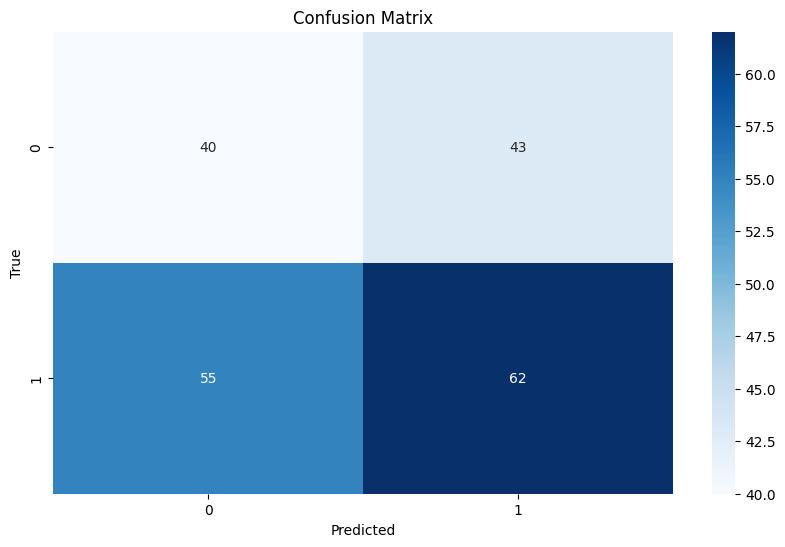

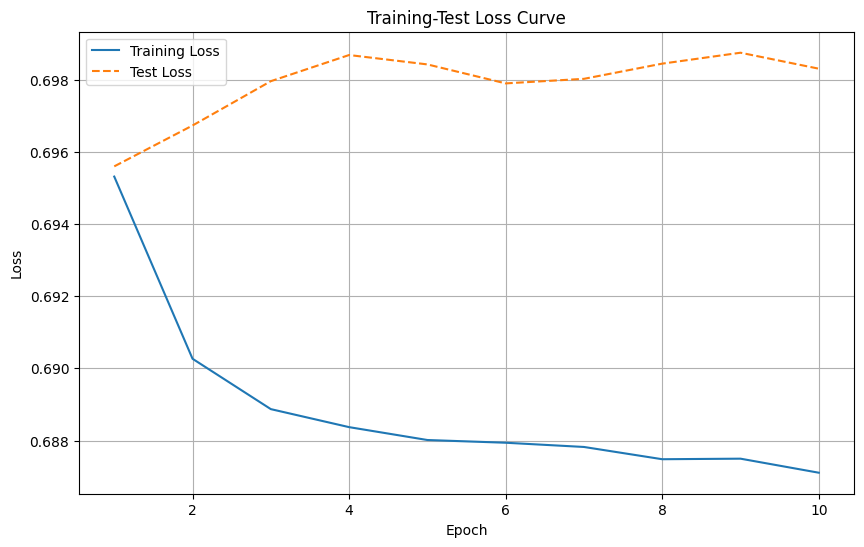

In [12]:
def plot_conf_matrix(all_preds, all_labels):
    conf_matrix = confusion_matrix(all_preds, all_labels)
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def plot_cost_function(train_losses, test_losses, epochs=10):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label = 'Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label = 'Test Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training-Test Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()


plot_conf_matrix(all_preds, all_labels)
plot_cost_function(train_losses, test_losses)

It appears that the model overfits on the training data as the test loss is increasing.

### Step 6: Save and Load Model

In [13]:
torch.save(model.state_dict(), 'model.pth')

In [14]:
loaded_model = LogisticRegressionNet(8)
loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model.eval()

LogisticRegressionNet(
  (linear): Linear(in_features=8, out_features=2, bias=True)
)

### Step 7: Hyperparameter Tuning

Use hyperparameter tuning to find the best learning rate for the optimizer.

In [24]:
learning_rates = [0.001, 0.01, 0.1, 0.5]
param_grid = {
    'learning_rate': learning_rates,
}



# perform grid search
best_loss = 10.0
best_lr = None
for params in ParameterGrid(param_grid):
    lr = params['learning_rate']
    optimizer = optim.SGD(loaded_model.parameters(), lr=lr, momentum=0.09, weight_decay=0.0001)
    train_losses, test_losses, all_preds, all_labels = model_training_eval(
        train_loader=train_loader,
        test_loader=test_loader,
        model=model_2,
        criterion=criterion,
        optimizer=adjusted_optimizer,
        epochs=10,
        show_losses=False
    )
    if test_losses[-1] < best_loss:
        best_loss = min(best_loss, test_losses[-1])
        best_lr = lr
    

print(best_lr)

0.001


### Step 8: Feature Importance

To evaluate feature importance, the weights of the linear layer can be extracted into a DataFrame and visualized.

In [27]:
# load the model
model = LogisticRegressionNet(8)
model.load_state_dict(torch.load('model.pth'))

# extract weights
weights = model.linear.weight.detach().numpy()
feature_names = X.columns.tolist()
feature_importance_df = pd.DataFrame(
    weights,
    columns= feature_names,
    index = ['Training', 'Test']
)
feature_importance_df.head()

,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
Training,-0.320468,-0.040699,-0.213872,-0.153355,-0.232374,-0.184451,0.153045,0.288331
Test,0.011036,-0.105653,-0.178313,0.267399,-0.158593,0.216186,0.036754,0.228496


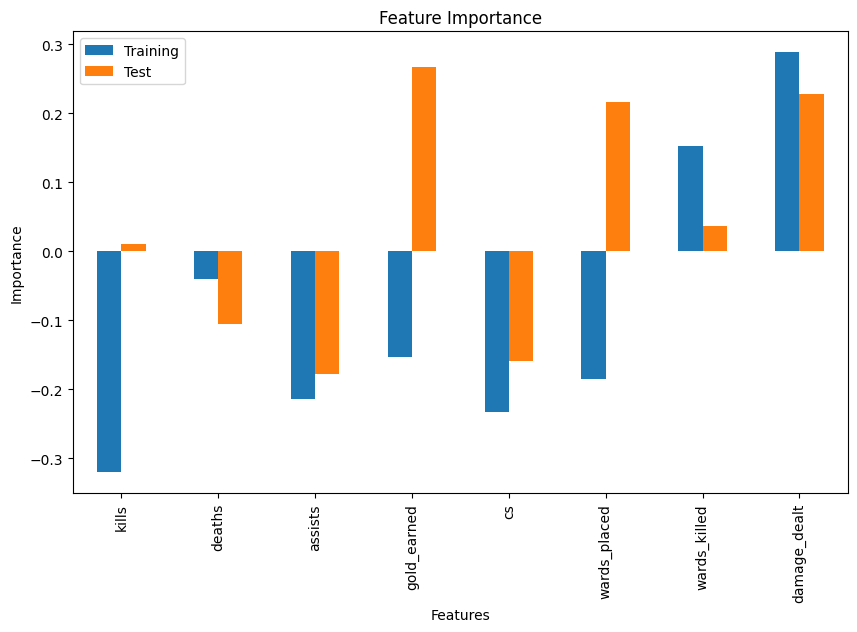

In [33]:
# plot feature importance
feature_importance_df = feature_importance_df.T
feature_importance_df.plot(kind = 'bar', figsize=(10, 6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
